### Project 2: Deer Park
Stuart Kwan - COMP215 - 2024-04-02\
This project aims to simulate a park with grazing deer, which live or die based on whether or not they eat enough foliage, to determine the critical point where the deer population goes into an equilibrium.

Credit: Reused code taken from Joseph Fall's Lab 7-10 - Forest Fire Model, [MIT Lisence](https://github.com/powderflask/cap-comp215/blob/2024.01/LICENSE)

#### Imports

In [4]:
# Imports
import pprint
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

#### Animation & Graphing

In [5]:
# Block taken from Lab 7-10 - fire
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()
    axes.set_title(title)
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [6]:
# Animate Class taken from Lab 7-10 - fire
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

#### Simulation

In [7]:
# Grazing Class
class Grazing:
    EMPTY = 0
    GRASS = 1
    DEER = 5
    step_count = 0

    cmap = [(0.8, 0.5, 0.2), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0.8, 0.4, 0)]
    cmap[EMPTY] = (0.8, 0.5, 0.2)
    cmap[GRASS] = (0, 1, 0)
    cmap[DEER] = (0.8, 0.4, 0)
    deerpark_cmap = matplotlib.colors.ListedColormap(cmap)

    kernel = np.array([[1, 1, 1], 
                       [1, 0, 1], 
                       [1, 1, 1]])

    def __init__(self, n=20, p=0.25, d=0.15, q=0.5):
        # Creates a start state and initalizes n (rows), p (grass regeneration), q (starting grass), and d (starting deer)
        self.p = p
        self.state = np.random.choice([self.GRASS, self.EMPTY], (n, n), p=[q, 1 - q])
        self.state = np.random.choice([self.DEER, self. EMPTY], (n, n), p=[d, 1 - d])


    def step(self):
        # Checks for all empty cells and randomly changes 
        empty = self.state == self.EMPTY
        # Randomly sets empty cells to grass depending on the amount of cells and the given probability 
        self.state[empty] = np.random.choice([self.GRASS, self.EMPTY], len(self.state[empty]), p=(self.p, 1-self.p))

        # Deer can move in any direction
        # Correlating neighbours to determine if next to grass
        transition = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        next_to_grass = transition >= self.DEER

        deer = self.state == self.DEER
        self.state[deer] = self.EMPTY
        
        # if next to grass, eat grass & gain 1 deer val, else lose 1 deer val for that specific deer
        # when deer val == 0, become empty, when deer val == 5, 
        self.state[next_to_grass & (self.state != self.EMPTY)] = self.DEER 

        
    def deer_pop(self):
        return len(self.state[self.state == self.DEER])

    def deer_pct(self):
        return self.deer_pop() / self.state.size

    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.deer_pct() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.deerpark_cmap, vmin=0, vmax=len(self.deerpark_cmap.colors))

In [8]:
deerpark = Grazing()

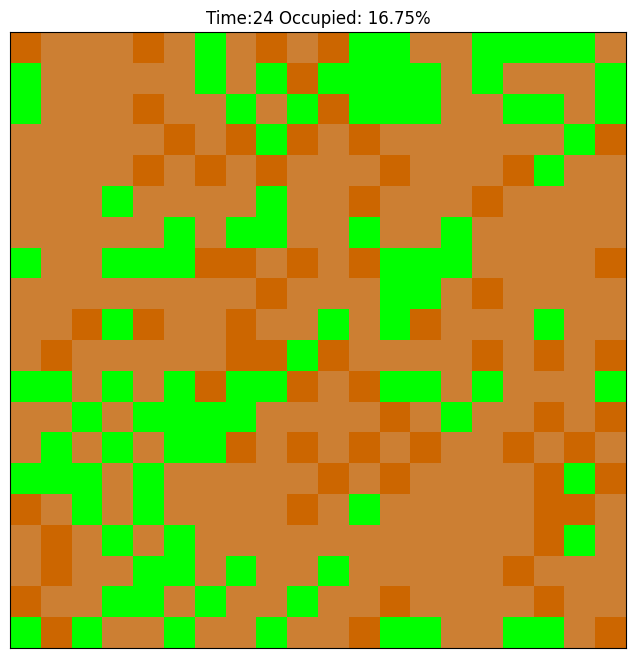

In [9]:
deerpark_ani = Animation2D(deerpark, 25)
deerpark_ani.animate(0.75)

#### Equilibrium Tests